In [1]:

import copy
import os

import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import seaborn as sns
import torch
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from pyro.infer import Predictive
from torch.utils.data import DataLoader

from cities.modeling.evaluation import prep_data_for_test, test_performance
from cities.modeling.svi_inference import run_svi_inference

from cities.modeling.zoning_models.zoning_tracts_model import TractsModel
from cities.utils.data_loader import select_from_data

smoke_test = "CI" in os.environ

n_steps = 10 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

In [2]:
census_tracts_data_path = os.path.join(
    root, "data/minneapolis/processed/pg_census_tracts_dataset.pt"
)

ct_dataset_read = torch.load(census_tracts_data_path)
ct_loader = DataLoader(ct_dataset_read, batch_size=len(ct_dataset_read), shuffle=True)
data = next(iter(ct_loader))

kwargs = {
    "categorical": ["year", "census_tract"],
    "continuous": {
        "housing_units",
        "total_value",
        "median_value",
        "mean_limit_original",
        "median_distance",
        "income",
        "segregation_original",
        "white_original",
    },
    "outcome": "housing_units",
}

subset = select_from_data(data, kwargs)

/tmp/ipykernel_18655/1945663762.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_dataset_read = torch.load(census_tracts_data_path)


In [3]:
# instantiation and prior predictive run

tracts_model = TractsModel(
    **subset, categorical_levels=ct_dataset_read.categorical_levels
)

with pyro.poutine.trace() as tr:
    tracts_model(**subset)

assert tr.trace.nodes["housing_units"]["value"].shape == torch.Size([1130])

/home/rafal/miniconda3/envs/polis-dev-new-pyro/lib/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


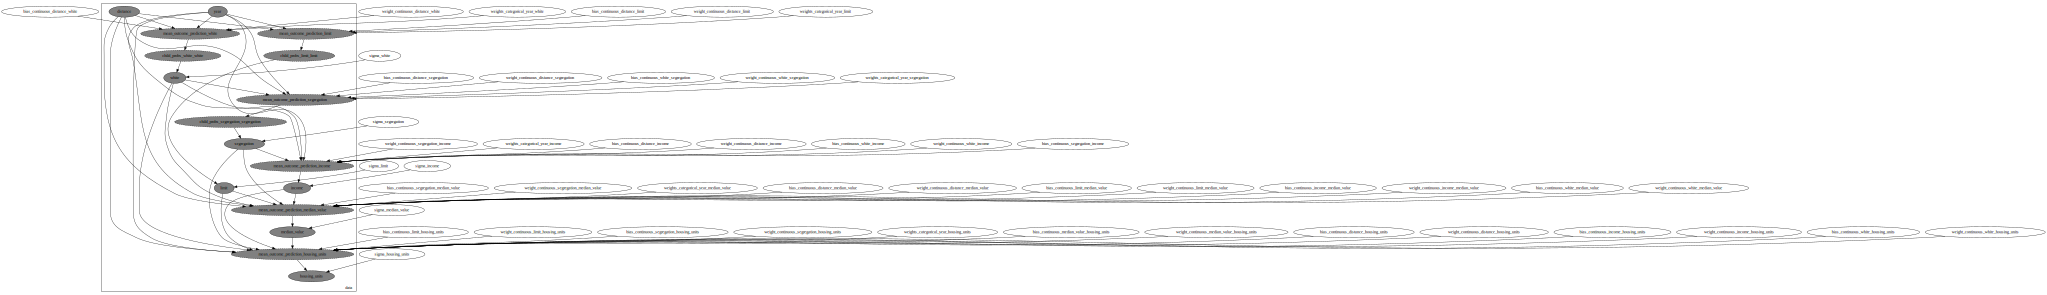

In [4]:
pyro.render_model(
    lambda: tracts_model(**subset),
    render_deterministic=True,
)

/home/rafal/s78projects/cities/cities/modeling/evaluation.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  zoning_dataset_read = torch.load(data_path)


[iteration 0001] loss: 169144.0156
[iteration 0050] loss: 42154.8438
[iteration 0100] loss: 31089.6465
[iteration 0150] loss: 16092.8262
[iteration 0200] loss: 11983.6631
[iteration 0250] loss: 10786.9307
[iteration 0300] loss: 9556.5352
[iteration 0350] loss: 9419.6348
[iteration 0400] loss: 7029.0791
[iteration 0450] loss: 6609.7495
[iteration 0500] loss: 6858.9468
[iteration 0550] loss: 6380.1763
[iteration 0600] loss: 5875.7539
[iteration 0650] loss: 5518.3154
[iteration 0700] loss: 5462.4009
[iteration 0750] loss: 5197.9136
[iteration 0800] loss: 5082.6880
[iteration 0850] loss: 5060.2876
[iteration 0900] loss: 4821.6123
[iteration 0950] loss: 4838.4321
[iteration 1000] loss: 4674.6714
[iteration 1050] loss: 5013.2036
[iteration 1100] loss: 4696.3354
[iteration 1150] loss: 4730.8848
[iteration 1200] loss: 4698.2148
[iteration 1250] loss: 4726.6411
[iteration 1300] loss: 4645.5542
[iteration 1350] loss: 4618.6313
[iteration 1400] loss: 4628.1255
[iteration 1450] loss: 4697.8950
[it

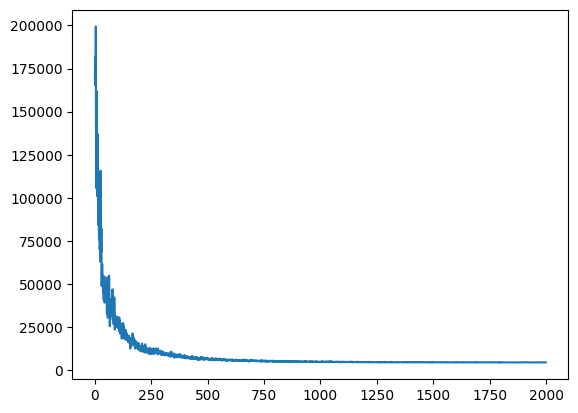

tensor(0.1344) tensor(0.0754)


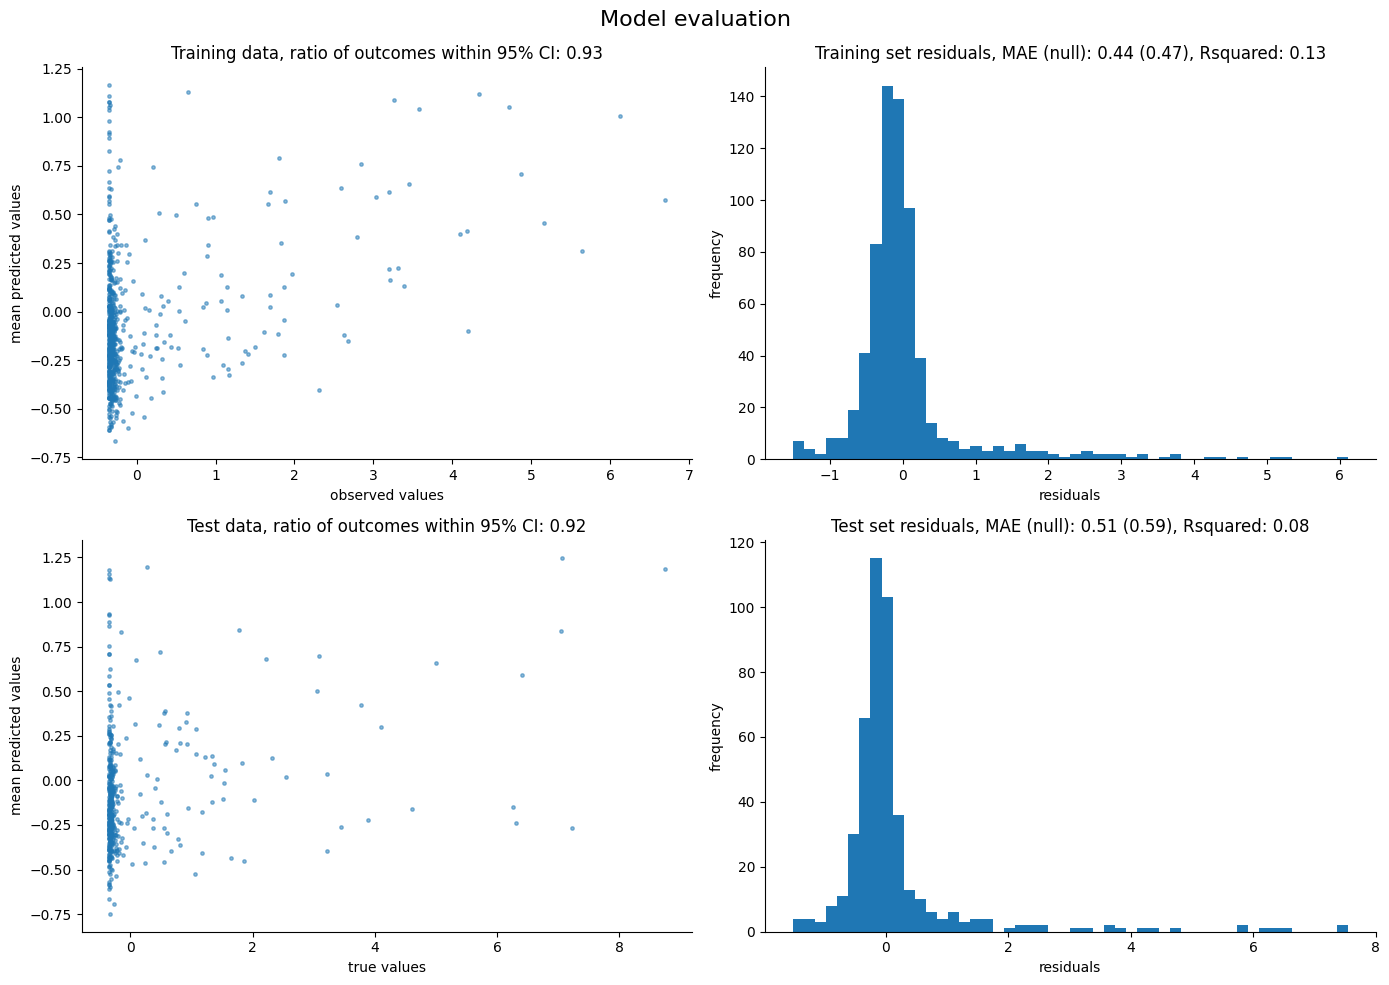

In [5]:
pyro.clear_param_store()


train_loader, test_loader, categorical_levels = prep_data_for_test(
    census_tracts_data_path, train_size=0.6
)

performance_results = test_performance(
    tracts_model,
    kwargs,
    train_loader,
    test_loader,
    categorical_levels,
    outcome_type="continuous",
    outcome_name="housing_units",
    n_steps=n_steps,
    plot=True,
    is_class=False,
)

In [8]:
ct_dataset_read.standardization_dictionary

{'housing_units_original': {'mean': tensor(31.1124), 'std': tensor(90.1668)},
 'total_value_original': {'mean': tensor(3.5076e+08),
  'std': tensor(4.5121e+08)}}

In [9]:
def destandardize_housing_units(column):
    mean = ct_dataset_read.standardization_dictionary["housing_units_original"]["mean"]
    std = ct_dataset_read.standardization_dictionary["housing_units_original"]["std"]

    return (column * std + mean).round()


mae_improvement_train = destandardize_housing_units(
    performance_results["mae_null_train"] - performance_results["mae_train"]
)
mae_improvement_test = destandardize_housing_units(
    performance_results["mae_null_test"] - performance_results["mae_test"]
)

print(
    f"MAE improvements on the original scale: {mae_improvement_test, mae_improvement_train}"
)

MAE improvements on the original scale: (tensor(39.), tensor(34.))


[iteration 0001] loss: 355762.3750
[iteration 0050] loss: 29607.4043
[iteration 0100] loss: 12165.6787
[iteration 0150] loss: 12125.0234
[iteration 0200] loss: 10227.2344
[iteration 0250] loss: 9133.0342
[iteration 0300] loss: 8257.4150
[iteration 0350] loss: 7912.2827
[iteration 0400] loss: 7996.8706
[iteration 0450] loss: 7689.5508
[iteration 0500] loss: 7678.6460
[iteration 0550] loss: 7780.4038
[iteration 0600] loss: 7596.4351
[iteration 0650] loss: 7664.7012
[iteration 0700] loss: 7686.1870
[iteration 0750] loss: 7600.6221
[iteration 0800] loss: 7621.7622
[iteration 0850] loss: 7566.8071
[iteration 0900] loss: 7723.4531
[iteration 0950] loss: 7551.1177
[iteration 1000] loss: 7545.3086
[iteration 1050] loss: 7685.6660
[iteration 1100] loss: 7598.7627
[iteration 1150] loss: 7543.4282
[iteration 1200] loss: 7510.1519
[iteration 1250] loss: 7518.4746
[iteration 1300] loss: 7431.3042
[iteration 1350] loss: 7472.3022
[iteration 1400] loss: 7455.0454
[iteration 1450] loss: 7465.4121
[ite

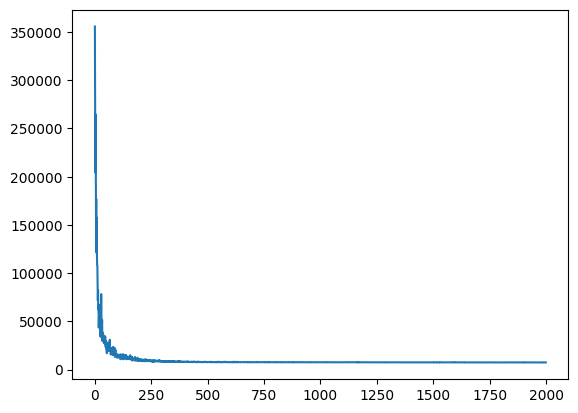

In [10]:
pyro.clear_param_store()
guide = run_svi_inference(tracts_model, n_steps=n_steps, lr=0.03, **subset)

predictive = Predictive(tracts_model, guide=guide, num_samples=num_samples)

subset_for_preds = copy.deepcopy(subset)
subset_for_preds["continuous"]["housing_units"] = None

preds = predictive(**subset_for_preds)

In [11]:
if not smoke_test:
    serialized_guide = dill.dumps(guide)
    file_path = os.path.join(root, "data/minneapolis/guides", f"tracts_model_guide_pg.pkl")
    with open(file_path, "wb") as file:
        file.write(serialized_guide)

    param_path = os.path.join(
        root, "data/minneapolis/guides", "tracts_model_params_pg.pth"
    )

    pyro.get_param_store().save(param_path)

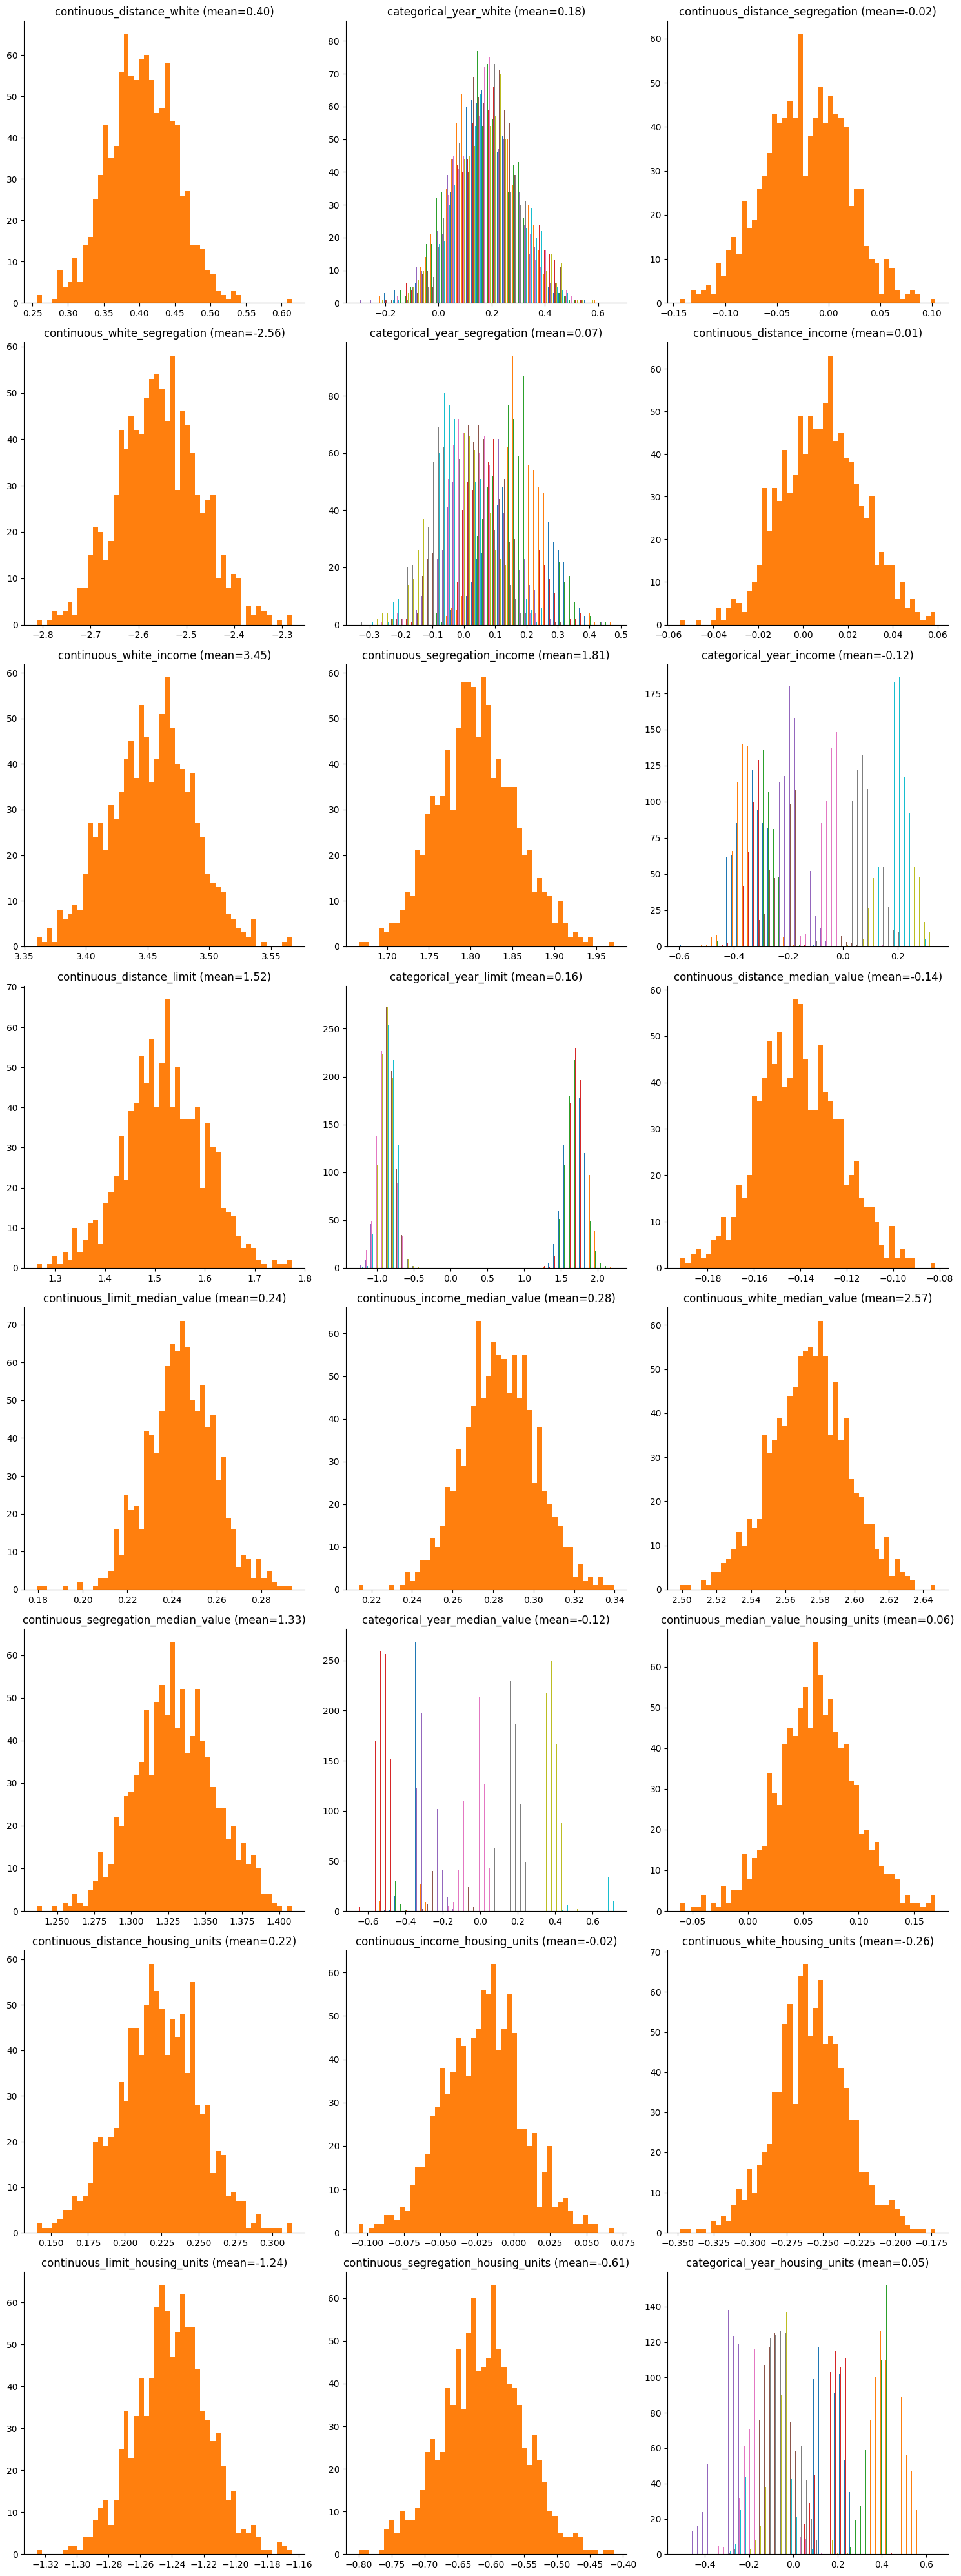

In [12]:
weight_keys = [key for key in preds.keys() if key.startswith("weight")]

n_keys = len(weight_keys)
n_cols = 3
n_rows = (n_keys + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axs = axs.flatten()

for i, key in enumerate(weight_keys):
    mean_val = preds[key].mean().item()
    axs[i].hist(preds[key].squeeze().detach().numpy(), bins=50)
    key_title = key.replace("weights_", "").replace("weight_", "")
    axs[i].hist(preds[key].squeeze().detach().numpy(), bins=50)
    axs[i].set_title(f"{key_title} (mean={mean_val:.2f})")


for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

sns.despine()
plt.tight_layout()
plt.show()

torch.Size([10, 3, 1, 1, 1, 1130])
torch.Size([10, 3, 1, 1, 1, 1130])
tensor(0.1769) tensor(0.2676) tensor(0.1415)


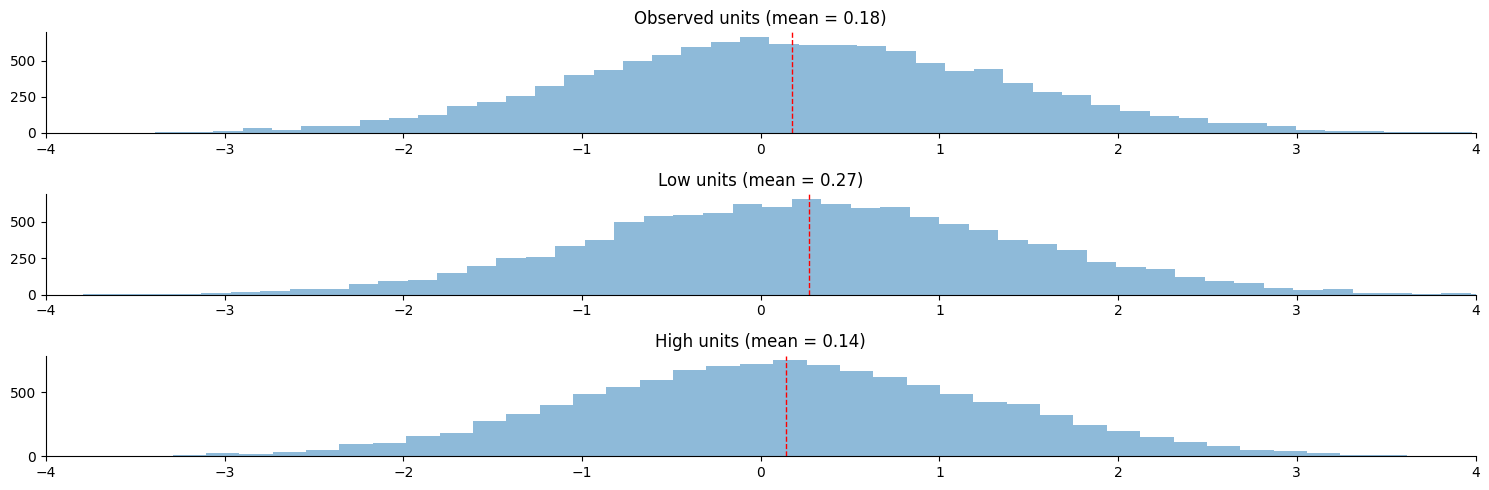

In [13]:
predictive = Predictive(tracts_model, guide=guide, num_samples=10, parallel=True)

with MultiWorldCounterfactual() as mwc:
    with do(actions={"limit": (torch.tensor(0.0), torch.tensor(1.0))}):
        samples = predictive(**subset_for_preds)

print(samples["limit"].shape)
print(samples["housing_units"].shape)

value = samples["limit"]
outcome = samples["housing_units"]

with mwc:
    observed_limit = gather(value, IndexSet(**{"limit": {0}}), event_dims=0)
    low_limit = gather(value, IndexSet(**{"limit": {1}}), event_dims=0)
    high_limit = gather(value, IndexSet(**{"limit": {2}}), event_dims=0)

    observed_units = gather(outcome, IndexSet(**{"limit": {0}}), event_dims=0)
    low_units = gather(outcome, IndexSet(**{"limit": {1}}), event_dims=0)
    high_units = gather(outcome, IndexSet(**{"limit": {2}}), event_dims=0)


fig, axes = plt.subplots(3, 1, figsize=(15, 5))


observed_mean = observed_units.mean()
low_mean = low_units.mean()
high_mean = high_units.mean()

print(observed_mean, low_mean, high_mean)

axes[0].hist(
    observed_units.flatten().detach().numpy(), bins=50, alpha=0.5, label="observed"
)
axes[0].axvline(observed_mean, color="r", linestyle="dashed", linewidth=1)
axes[0].set_title(f"Observed units (mean = {observed_mean:.2f})")
axes[0].set_xlim(-4, 4)

axes[1].hist(low_units.flatten().detach().numpy(), bins=50, alpha=0.5, label="low")
axes[1].axvline(low_mean, color="r", linestyle="dashed", linewidth=1)
axes[1].set_title(f"Low units (mean = {low_mean:.2f})")
axes[1].set_xlim(-4, 4)

axes[2].hist(high_units.flatten().detach().numpy(), bins=50, alpha=0.5, label="high")
axes[2].axvline(high_mean, color="r", linestyle="dashed", linewidth=1)
axes[2].set_title(f"High units (mean = {high_mean:.2f})")
axes[2].set_xlim(-4, 4)

plt.tight_layout()
sns.despine()
plt.show()

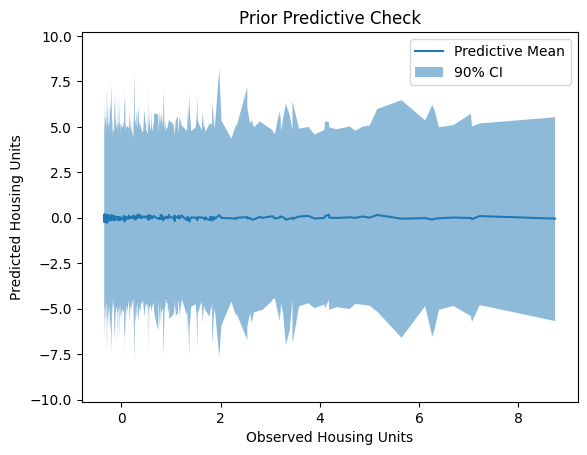

In [14]:
# prior_predictive_check
# less wild than that without the ratio mechanisms


prior_predictive = Predictive(tracts_model, num_samples=num_samples)


prior_samples = prior_predictive(**subset_for_preds)

samples_outcome = prior_samples["housing_units"]
pred_means = samples_outcome.mean(axis=0)
pred_low = samples_outcome.quantile(0.05, axis=0)
pred_high = samples_outcome.quantile(0.95, axis=0)


prior_df = pd.DataFrame(
    {
        "housing_units": subset["continuous"]["housing_units"],
        "pred_means": pred_means,
        "pred_low": pred_low,
        "pred_high": pred_high,
    }
)

# sort priod_df by housing_units
prior_df = prior_df.sort_values(by="housing_units")


plt.plot(prior_df["housing_units"], prior_df["pred_means"], label="Predictive Mean")
plt.fill_between(
    prior_df["housing_units"],
    prior_df["pred_low"],
    prior_df["pred_high"],
    alpha=0.5,
    label="90% CI",
)
plt.xlabel("Observed Housing Units")
plt.ylabel("Predicted Housing Units")
plt.title("Prior Predictive Check")
plt.legend()
plt.show()

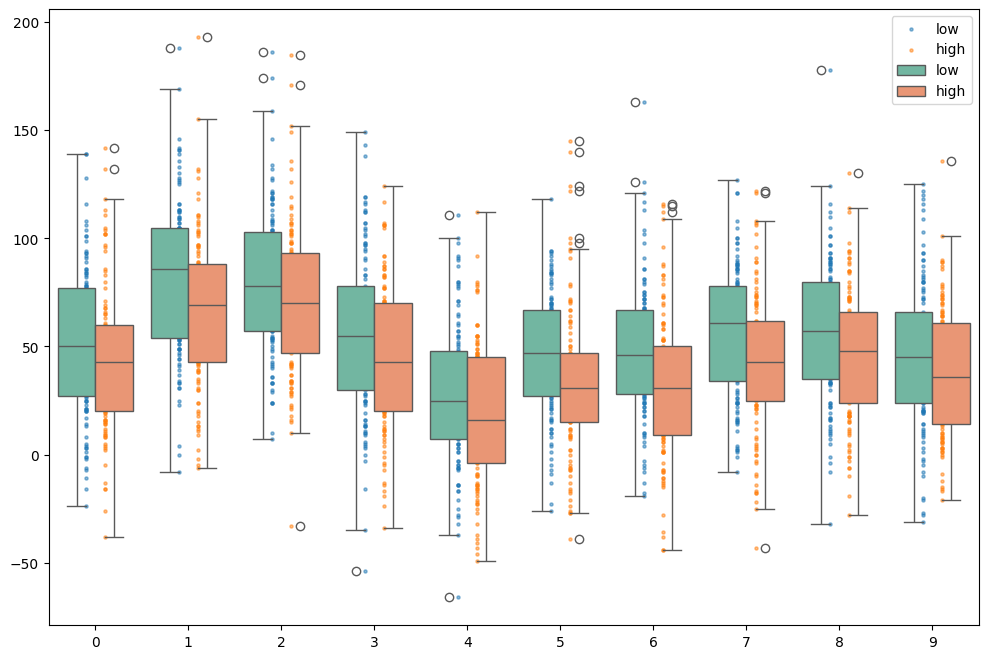

In [21]:
years = data["categorical"]["year"].flatten().detach().numpy()
years_full = years - 0.1
years_no = years + 0.1


plt.figure(figsize=(12, 8))
plt.scatter(
    x=years_full,
    y=destandardize_housing_units(low_units.mean(axis=0).flatten().detach()),
    s=5,
    alpha=0.5,
    label="low",
)


plt.scatter(
    x=years_no,
    y=destandardize_housing_units(high_units.mean(axis=0).flatten().detach()),
    s=5,
    alpha=0.5,
    label="high",
)


data_combined = np.concatenate(
    (
        destandardize_housing_units(low_units.mean(axis=0).flatten()),
        destandardize_housing_units(high_units.mean(axis=0).flatten()),
    )
)
years_combined = np.concatenate((years, years))
labels_combined = np.concatenate(
    (np.repeat("low", len(years)), np.repeat("high", len(years)))
)


boxplot = sns.boxplot(
    x=years_combined,
    y=data_combined,
    hue=labels_combined,
    dodge=True,
    palette="Set2",
)

plt.legend()
plt.show()